### Task VI: Quantum representation learning

In this task you should implement a simple representation learning scheme based on a contrastive loss:
Load the MNIST dataset

Write a function which takes an image and prepares a quantum state. This function should have trainable parameters which we want to learn in order to have good quantum representations

Create a circuit with which takes two images and embeds both as quantum states with the function you wrote before. Afterwards the circuit should perform a SWAP test between the two states. 

In the end the measurement should give the fidelity of the quantum states.


#### Model Definition

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torchvision.transforms as T
import kornia
import torchmetrics
from pytorch_metric_learning import losses

import os

# Define available activations and pooling types
_ACTIVATIONS = {"relu": nn.ReLU, "gelu": nn.GELU}
_POOLING = {"max": nn.MaxPool2d, "avg": nn.AvgPool2d}

def contrastive_loss_with_margins(embeddings, labels, pos_margin=0.25, neg_margin=1.5):
    # Pairwise distance matrix
    distance_matrix = torch.cdist(embeddings, embeddings, p=2)
    
    # Loss components based on the margins
    # For positive pairs (labels == 0)
    positive_loss = (1 - labels) * F.relu(distance_matrix - pos_margin).pow(2)
    
    # For negative pairs (labels == 1)
    negative_loss = labels * F.relu(neg_margin - distance_matrix).pow(2)
    
    # Combine the losses
    combined_loss = 0.5 * (positive_loss + negative_loss)
    
    # Mask out identical items
    mask = torch.eye(labels.size(0), dtype=torch.bool, device=labels.device)
    combined_loss = combined_loss.masked_fill_(mask, 0)
    
    # Aggregate
    loss = combined_loss.mean()
    
    return loss

class ConvUnit(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, stride, padding, pool_type, pool_kernel_size, pool_stride, activ_type):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(output_channels)
        self.activ = _ACTIVATIONS[activ_type]()
        self.pool = _POOLING[pool_type](kernel_size=pool_kernel_size, stride=pool_stride)

    def forward(self, x):
        return self.pool(self.activ(self.bn(self.conv(x))))

class MNISTConvEncoder(nn.Module):
    backbone_output_size = 196
    def __init__(self, activ_type, pool_type):
        super().__init__()
        self.conv_unit1 = ConvUnit(1, 4, 3, 1, 1, pool_type, 2, 2, activ_type)
        self.conv_unit2 = ConvUnit(4, 4, 3, 1, 1, pool_type, 2, 2, activ_type)

    def forward(self, x):
        x = self.conv_unit1(x)
        x = self.conv_unit2(x)
        return x.view(-1, self.backbone_output_size)

class LinearHead(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.head = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.head(x)

class MNISTSupContrast(pl.LightningModule):
    def __init__(self, activ_type, pool_type, head_output, lr, pos_margin=0.25, neg_margin=1.5, preprocess=None):
        super().__init__()
        self.save_hyperparameters()
        self.preprocessing = self.get_preprocessing(preprocess)
        self.encoder = MNISTConvEncoder(activ_type, pool_type)
        self.head = LinearHead(MNISTConvEncoder.backbone_output_size, head_output)
        self.loss = losses.ContrastiveLoss(pos_margin=pos_margin, neg_margin=neg_margin)
        # self.loss = contrastive_loss_with_margins
        self.train_loss = torchmetrics.MeanMetric()
        self.valid_loss = torchmetrics.MeanMetric()

    def get_preprocessing(self, preprocess):
        if preprocess == "RandAffine":
            return kornia.augmentation.RandomAffine(degrees=(-40, 40), translate=0.25, scale=[0.5, 1.5], shear=45)
        elif preprocess == "RandAug":
            return T.RandAugment()
        return None

    def forward(self, x):
        x = self.encoder(x)
        x = self.head(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        if self.preprocessing:
            x = self.preprocessing(x)
        embeddings = self.forward(x)
        loss = self.loss(embeddings, y)
        self.train_loss.update(loss)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        if self.preprocessing:
            x = self.preprocessing(x)
        embeddings = self.forward(x)
        loss = self.loss(embeddings, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


#### Loading Data

In [24]:
from torchvision import datasets, transforms as T
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np

# Define transformations
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.1307,), (0.3081,))
])

# Download and load the MNIST dataset
dataset = datasets.MNIST(root="data/", train=True, download=True, transform=transform)

# Filter the dataset to keep only items with labels 0 or 1
filtered_indices = [i for i, (_, label) in enumerate(dataset) if label in [0, 1, 5]]
filtered_dataset = Subset(dataset, filtered_indices)

# Split the filtered dataset into training and validation sets
train_size = int(0.9 * len(filtered_dataset))  # Using 90% for training, 10% for validation as an example
val_size = len(filtered_dataset) - train_size
train_dataset, val_dataset = random_split(filtered_dataset, [train_size, val_size])

# Prepare data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=12)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=12)

#### Plot (projection of) generated embeddings pre-training

/tmp/ipykernel_15344/1481501735.py:10: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(


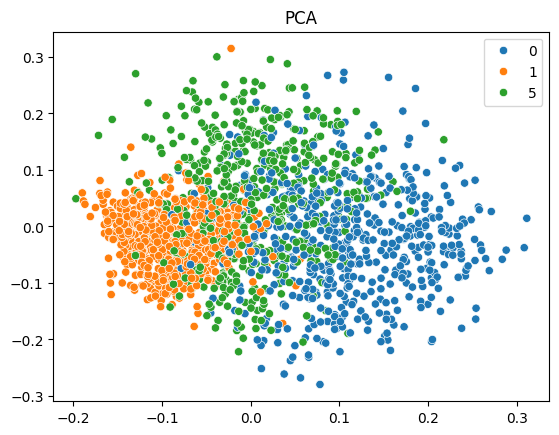

/tmp/ipykernel_15344/1481501735.py:20: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(


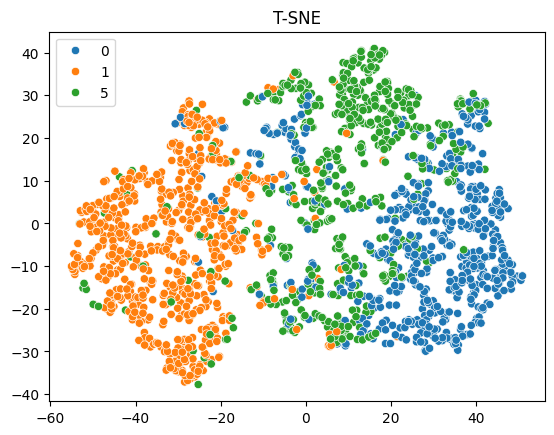

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

model = MNISTSupContrast(activ_type="relu", pool_type="max", head_output=4, lr=1e-3)

def pca_proj(embeddings, labels, seed=1):
    proj = PCA(n_components=2, random_state=seed).fit_transform(embeddings)
    sns.scatterplot(
        x=proj[:, 0],
        y=proj[:, 1],
        hue=labels,
        palette=sns.color_palette("tab10"),
    ).set(title="PCA")
    plt.show()

def tsne_proj(embeddings, labels, seed=1):
    proj = TSNE(n_components=2, random_state=seed).fit_transform(embeddings)
    sns.scatterplot(
        x=proj[:, 0],
        y=proj[:, 1],
        hue=labels,
        palette=sns.color_palette("tab10"),
    ).set(title="T-SNE")
    plt.show()

def generate_embeddings(model, data_loader):
    model.eval()  # Set model to evaluation mode
    embeddings = []
    labels = []
    
    with torch.no_grad():  # No gradients required
        for i, batch in enumerate(data_loader):
            # if i >= 5:  # Only process the first 5 batches
            #     break
            x, y = batch
            x = model.encoder(x)
            # print(f"Shape after encoder: {x.shape}")
            emb = model.head(x)  # Assuming model.encoder gives the desired embeddings
            # print(f"Shape after head: {emb.shape}")
            embeddings.append(emb)
            labels.append(y)
    
    embeddings = torch.cat(embeddings).cpu().numpy()
    labels = torch.cat(labels).cpu().numpy()
    
    return embeddings, labels

embeddings, labels = generate_embeddings(model, val_loader)

pca_proj(embeddings, labels)

tsne_proj(embeddings, labels)

#### Training the Model

In [29]:
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import Trainer

# Define a logger
logger = CSVLogger(save_dir="logs/", name="MNISTContrast", version=0)

# Define the trainer
trainer = Trainer(max_epochs=10, logger=logger, gpus=1 if torch.cuda.is_available() else 0)

# Start the training process
trainer.fit(model, train_loader, val_loader)

/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoin

Sanity Checking: 0it [00:00, ?it/s]

Epoch 9: 100%|██████████| 284/284 [00:07<00:00, 36.09it/s, loss=0.315, v_num=0, val_loss=0.315, train_loss=0.261]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 284/284 [00:07<00:00, 36.00it/s, loss=0.315, v_num=0, val_loss=0.315, train_loss=0.261]


#### Plot (projection of) generated embeddings post-training

/tmp/ipykernel_15344/1481501735.py:10: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(


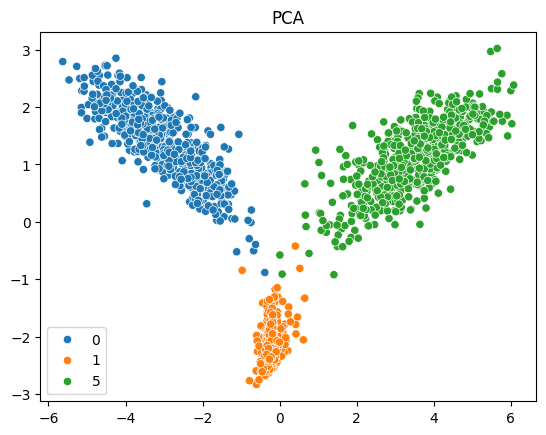

/tmp/ipykernel_15344/1481501735.py:20: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(


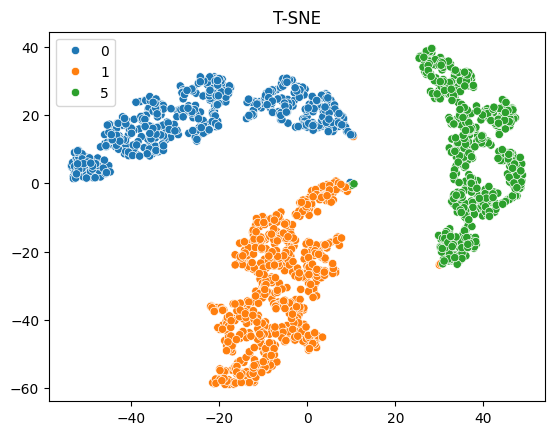

In [30]:
embeddings, labels = generate_embeddings(model, val_loader)

# PCA Projection
pca_proj(embeddings, labels)

# t-SNE Projection
tsne_proj(embeddings, labels)

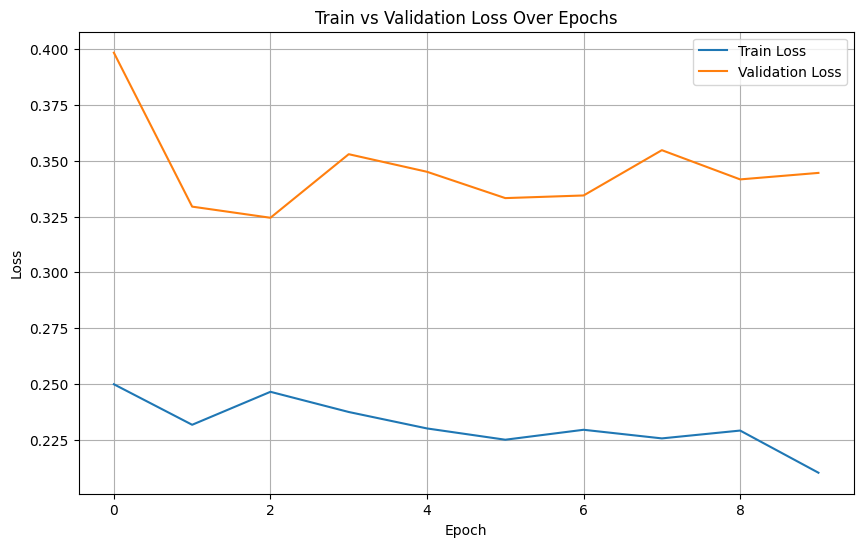

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the logger's name and version directory are correctly set
log_dir = logger.log_dir

# Load the metrics from the CSV file into a DataFrame
metrics_df = pd.read_csv(f"{log_dir}/metrics.csv")

# Extract epoch-level training and validation loss
train_loss_epoch = metrics_df['train_loss'].dropna().reset_index(drop=True)
valid_loss_epoch = metrics_df['valid_loss'].dropna().reset_index(drop=True)

# Ensure both series have the same length for plotting
min_length = min(len(train_loss_epoch), len(valid_loss_epoch))
train_loss_epoch = train_loss_epoch[:min_length]
valid_loss_epoch = valid_loss_epoch[:min_length]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_loss_epoch, label='Train Loss')
plt.plot(valid_loss_epoch, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


#### Encode embedding in quantum state

In [66]:
import pennylane as qml
from pennylane import numpy as np

def swap_test_circuit(embedding1, embedding2):
    """Defines a quantum circuit for the SWAP test to compare two embeddings."""
    # Calculate the total number of qubits needed for one embedding
    num_qubits_per_embedding = int(np.ceil(np.log2(len(embedding1))))
    total_num_qubits = 2 * num_qubits_per_embedding + 1  # +1 for the ancilla qubit

    dev = qml.device('default.qubit', wires=total_num_qubits)
    
    @qml.qnode(dev)
    def circuit(embedding1, embedding2):
        qml.Hadamard(wires=0)
        qml.AmplitudeEmbedding(features=embedding1, 
                               wires=range(1, num_qubits_per_embedding + 1), normalize=True)
        qml.AmplitudeEmbedding(features=embedding2, 
                               wires=range(num_qubits_per_embedding + 1, 2 * num_qubits_per_embedding + 1), normalize=True)
        
        # Apply SWAP test
        for i in range(1, num_qubits_per_embedding + 1):
            qml.CSWAP(wires=[0, i, i + num_qubits_per_embedding])
        qml.Hadamard(wires=0)
        
        return qml.expval(qml.PauliZ(0))
    
    return circuit(embedding1, embedding2)

In [64]:
# Load two images
img1, label1 = filtered_dataset[0]  
img2, label2 = filtered_dataset[0] 

print("Label: ", label1, label2)
# Add a batch dimension [B, C, H, W] for model input
img1 = img1.unsqueeze(0) 
img2 = img2.unsqueeze(0)

model.eval()

with torch.no_grad():
    embedding1 = model.forward(img1).flatten().numpy()
    embedding2 = model.forward(img2).flatten().numpy()
    
fidelity = swap_test_circuit(embedding1, embedding2)
print("Fidelity (result of SWAP test):", fidelity)

Label:  5 5
Fidelity (result of SWAP test): 1.0


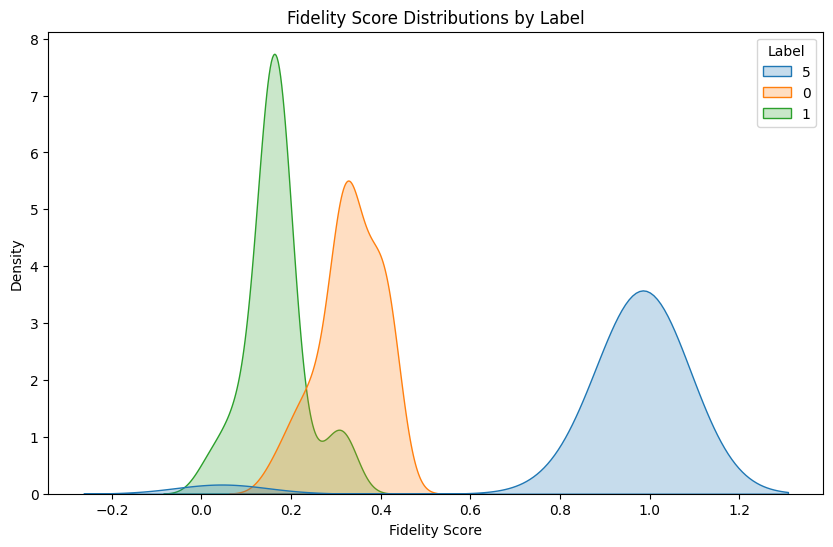

In [65]:
import pandas as pd
reference_image, reference_label = filtered_dataset[0]
reference_embedding = model.forward(reference_image.unsqueeze(0)).detach().numpy().flatten()

embeddings = []
labels = []

for i in range(100):
    image, label = filtered_dataset[i]
    embedding = model.forward(image.unsqueeze(0)).detach().numpy().flatten()
    embeddings.append(embedding)
    labels.append(label)

fidelity_scores = []
for embedding, label in zip(embeddings, labels):
    fidelity = swap_test_circuit(reference_embedding, embedding)
    fidelity_scores.append((fidelity.item(), str(label)))


df1 = pd.DataFrame(fidelity_scores, columns=['Fidelity', 'Label'])

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df1, x='Fidelity', hue='Label', common_norm=False, fill=True)
plt.title('Fidelity Score Distributions by Label')
plt.xlabel('Fidelity Score')
plt.ylabel('Density')
plt.show()

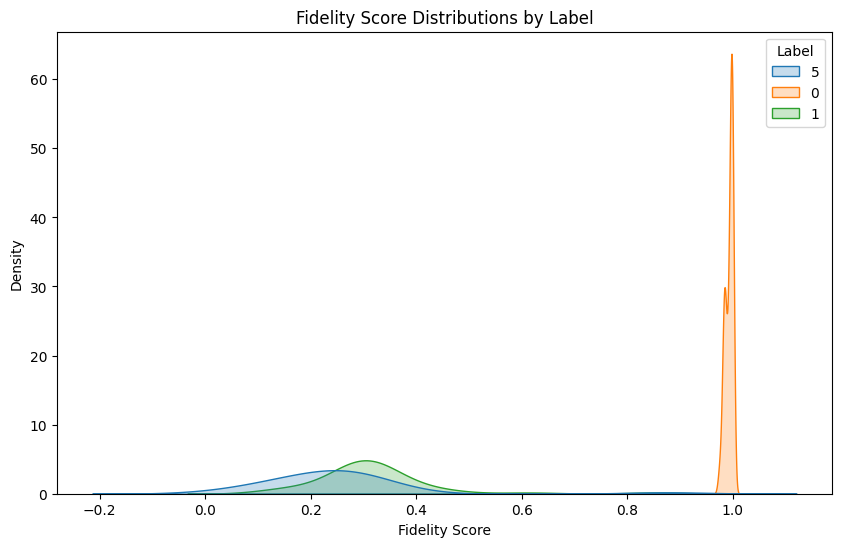

In [67]:
import pandas as pd
reference_image, reference_label = filtered_dataset[1]
reference_embedding = model.forward(reference_image.unsqueeze(0)).detach().numpy().flatten()

embeddings = []
labels = []

for i in range(100):
    image, label = filtered_dataset[i]
    embedding = model.forward(image.unsqueeze(0)).detach().numpy().flatten()
    embeddings.append(embedding)
    labels.append(label)

fidelity_scores = []
for embedding, label in zip(embeddings, labels):
    fidelity = swap_test_circuit(reference_embedding, embedding)
    fidelity_scores.append((fidelity.item(), str(label)))


df1 = pd.DataFrame(fidelity_scores, columns=['Fidelity', 'Label'])

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df1, x='Fidelity', hue='Label', common_norm=False, fill=True)
plt.title('Fidelity Score Distributions by Label')
plt.xlabel('Fidelity Score')
plt.ylabel('Density')
plt.show()

We have constructed a neural network function with trainable parameters. The function's output yields a compressed embedding, which could be efficiently encoded as quantum states.
This may seem trivial, as amplitude encoding could represent classical embedding values faithfully and we could expect the fidelity reflect the distance of embeddings. 
The next step would be training the parameters of variational circuit itself to generate embeddings with high fidelity for similar pairs of samples, low fidelity for dissimilar ones.